<a href="https://colab.research.google.com/github/lrvnc/backprop-tutorial/blob/main/backprop_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Feed-forward pass
---

Let $a^{(0)} \in \mathbb{R}^{N_{\text{in}} \times 1}$ be our input vector, and $a^{(k)} \in \mathbb{R}^{N_{\text{out}} \times 1}$ our network output. The superscript $(k)$ denotes the network layer.

We define a single feed-forward pass as:

1. A linear transformation: $z^{(l)} = W^{(l)} a^{(l)} + b^{(l)}$
2. Followed by a non-linear activation: $a^{(l+1)} = g(z^{(l)})$

Here, $W^{(l)} \in \mathbb{R}^{H_{\text{out}} \times H_{\text{in}}}$ and $b^{(l)} \in \mathbb{R}^{H_{\text{out}} \times 1}$ denote the weight matrix and bias vector of the layer, respectively, with $H_{\text{in}}$ and $H_{\text{out}}$ being the departure and arrival dimensions of the activation state $a^{(l)}$. The activation function $g(z)$ is non-linear and applied element-wise.

Let's implement the neuron activation. We also return $z$, which will be useful in a moment when we perform backpropagation.



In [138]:
def neuron_activation(a, W, b, g):

    assert a.shape[0] == W.shape[1], 'State vector must match H_in dimension of matrix W'
    assert W.shape[0] == b.shape[0], 'Bias vector must match H_out dimension of matrix W'

    z = W @ a + b
    a_next = g(z)
    return a_next, z

In [139]:
N_in = 10
N_out = 5
N_samples = 1

H_in = N_in
H_out = N_out

a_0 = np.random.randn(N_in, N_samples) # Random network input
W_0 = np.random.randn(H_out, H_in) # Random init input layer weight matrix
b_0 = np.random.randn(H_out, N_samples) # Random init input layer bias vector

# Let's consider the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return np.exp(x) / (1+np.exp(x))**2

a_1, z_0 = neuron_activation(a_0, W_0, b_0, sigmoid)
print(f'a_1: {a_1.flatten()}\nz_0: {z_0.flatten()}')


a_1: [0.11789992 0.95549146 0.40855618 0.26792657 0.28376881]
z_0: [-2.01246941  3.06654464 -0.36993728 -1.00516788 -0.92584316]


Now we can implement a feed-forward pass, which consists of chaining multiple neuron activations in sequence. To do that, we first decide how many layers we want, and what their dimensions should be.


We call the first layer the *input layer*, and the last one the *output layer*. Any layer in between is called a *hidden layer*.

In [4]:
N_in = 2
N_out = 1
N_samples = 1

ACTIVATIONS = {
    'sigmoid': {
        'function': sigmoid,
        'derivative': sigmoid_derivative
    }
}

network_config = {
    'layer_0': {
        'N_in': N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_1': {
        'N_in': 2*N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_2': {
        'N_in': 2*N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_3': {
        'N_in': 2*N_in,
        'N_out': N_out,
        'activation': 'sigmoid'
    },
}


def init_network(network_config):
    # Init layer weights and bias
    network = {}

    for layer_name, layer_config in network_config.items():
        network[layer_name] = {
            'W': np.random.randn(layer_config['N_out'], layer_config['N_in']),
            'b': np.random.randn(layer_config['N_out'], 1),
            'activation': layer_config['activation']
        }

    network['output'] = {}

    return network

network = init_network(network_config)

In [5]:
def feedforward(network, inputs):

    for layer_name, layer_params in network.items():

        if layer_name == 'output':
            continue

        network[layer_name]['a'] = inputs
        W = layer_params['W']
        b = layer_params['b']
        g = ACTIVATIONS[layer_params['activation']]['function']
        a_next, z = neuron_activation(inputs, W, b, g)
        network[layer_name]['z'] = z
        inputs = a_next

        network['output']['prediction'] = a_next

    return network

inputs = np.random.randn(N_in, 1)
network = feedforward(network, inputs)
network['output']['prediction']

array([[0.17652508]])

# Backpropagation
---

Now that we know how to compute the feed-forward pass (or the *inference*), we can implement the backpropagation step.

The goal of the backpropagation algorithm is to update the weights and bias values in a smart way that decreases a metric of our choice — what people usually call the **objective function** (or **loss function**, or the **network criterion**).

A natural metric we can think of is the distance between the value predicted by the network and the true value we wanted (or the **target value**). In mathematical terms, we have:

$$
L_2(\tilde{y}, y) = (\tilde{y} - y)^2
$$

We call this the **$L_2$ norm**, or the *Euclidean norm*, or the **mean squared error (MSE)**, where $\tilde{y}$ is the network output (or the network prediction), and $y$ its corresponding target value. We'll come back to this expression later when we do the computations later.

Nevertheless, what is this smart way of computing the changes in $W^{(l)}$ and $b^{(l)}$ to minimize the loss? The answer is: **derivatives**.

We could change $W$ and $b$ randomly, hoping that at some point we would get a minimal value. The process would be iterative: randomly pick $W$ and $b$ values, do the feed-forward pass, see how close the output is to the target, pick another $W$ and $b$, see if the prediction is closer to the target — if yes, stay with those $W$ and $b$ values, otherwise keep the last iteration — and repeat this as many times as you want.

If you could do this infinitely, at some moment you would eventually find the best configuration of weights and biases. However, this would take forever.

Instead, we use a well-known mathematical tool: **derivatives**, to get a better guess of how to change $W$ and $b$ and be more guided on how to update them.

We know that the derivative of a function with respect to a parameter (in our case, the loss function with respect to the weights or the biases) points toward the direction where the function is going. If the derivative is positive, the function is increasing; if it's negative, the function is decreasing.

A good analogy I like to think of is that the loss function is the map of the world — which we don't exactly know — and the derivative is the GPS. But the GPS only knows how to point out whether the terrain is going up or down at the point where you are. So, if your goal is to go down as much as you can, what you do is: take the derivative, and if it's positive, you go in the opposite direction; if it's negative, you keep following it.


But we already went too far — wait a second before starting to explore the map! We first need to know how to compute the derivatives.

Let $\mathcal{L}(\tilde y, y)$ be our loss function. We aim to compute $\frac{\partial \mathcal{L}}{\partial W^{(l)}}$ and $\frac{\partial \mathcal{L}}{\partial b^{(l)}}$.

From the feed-forward step we have:

1. $z^{(l)} = W^{(l)} a^{(l)} + b^{(l)}$
2. $a^{(l+1)} = g(z^{(l)})$

Let's call the network output $\tilde y = a^{(k)}$, the network's $k$-th activation. First, we backpropagate from the output:

$$
\frac{\partial}{\partial W^{(k-1)}} \mathcal{L}(a^{(k)}, y)
= \frac{\partial \mathcal{L}}{\partial a^{(k)}}
  \frac{\partial a^{(k)}}{\partial z^{(k-1)}}
  \frac{\partial z^{(k-1)}}{\partial W^{(k-1)}}
= \left[\delta_{(k)} \otimes g'(z^{(k-1)})\right] a^{(k-1)^T}
$$

And:

$$
\frac{\partial}{\partial b^{(k-1)}} \mathcal{L}(a^{(k)}, y)
= \frac{\partial \mathcal{L}}{\partial a^{(k)}}
  \frac{\partial a^{(k)}}{\partial z^{(k-1)}}
  \frac{\partial z^{(k-1)}}{\partial b^{(k-1)}}
= \delta_{(k)} \otimes g'(z^{(k-1)})
$$

Where $\otimes$ is the element-wise multiplication operator.

Following the same reasoning, for the earlier layers $k-2$, $k-3$, and so on, we write:

$$
\frac{\partial}{\partial W^{(k-2)}} \mathcal{L}(a^{(k)}, y)
= \frac{\partial \mathcal{L}}{\partial a^{(k)}}
  \frac{\partial a^{(k)}}{\partial z^{(k-1)}}
  \frac{\partial z^{(k-1)}}{\partial a^{(k-1)}}
  \frac{\partial a^{(k-1)}}{\partial z^{(k-2)}}
  \frac{\partial z^{(k-2)}}{\partial W^{(k-2)}}
= \left[W^{(k-1)^T} \delta_{(k)} \otimes g'(z^{(k-2)})\right] a^{(k-2)^T}
$$

So, defining:

$$
\delta^{(l)} =
\begin{cases}
  a^{(l)} - y & \text{if } l = k \\
  W^{(l)^T} \delta^{(l+1)} \otimes g'(z^{(l)}) & \text{if } l < k
\end{cases}
$$

We have the gradients:

$$
\frac{\partial \mathcal{L}}{\partial W^{(l)}} = \left[\delta_{(l+1)} \otimes g'(z^{(l)})\right] a^{(l)^T}, \quad \text{with } l \in \left[0, k-1\right]
$$

$$
\frac{\partial \mathcal{L}}{\partial b^{(l)}} = \delta_{(l+1)} \otimes g'(z^{(l)}), \quad \text{with } l \in \left[0, k-1\right]
$$


In [8]:
def l2(pred, tgt):
    assert pred.shape == tgt.shape, 'Network prediction and target must have the same dimensions'
    return 0.5 * (pred - tgt)**2

def l2_derivative(pred, tgt):
    assert pred.shape == tgt.shape, 'Network prediction and target must have the same dimensions'
    return pred - tgt

LOSSES = {
    'L2': {
        'function': l2,
        'derivative': l2_derivative
    }
}

def backprop(network, loss, tgt):

    assert tgt.shape == network['output']['prediction'].shape, f"Network output and target must have the same dimension (tgt: {tgt.shape}, pred: {network['output']['prediction'].shape})"

    network_size = len(network) - 2 # -1 to ignore 'output' and -1 because 0 indexed

    for layer_name, layer_params in reversed(list(network.items())):

        if layer_name == 'output': # l = k
            pred = network['output']['prediction']
            delta = LOSSES[loss]['derivative'](pred, tgt)
            continue

        if int(layer_name.split('_')[-1]) == network_size: # l < k
            activation_name = layer_params['activation']
            layer_params['db'] = delta * ACTIVATIONS[activation_name]['derivative'](layer_params['z'])
            layer_params['dW'] = layer_params['db'] @ layer_params['a'].T
            delta = layer_params['db']

        else:
            activation_name = layer_params['activation']
            layer_next = f"layer_{int(layer_name.split('_')[-1]) + 1}"
            layer_params['db'] = network[layer_next]['W'].T @ delta * ACTIVATIONS[activation_name]['derivative'](layer_params['z'])
            layer_params['dW'] = layer_params['db'] @ layer_params['a'].T
            delta = layer_params['db']

    return network


tgt = np.array([[1]])
network = backprop(network, 'L2', tgt)

In [9]:
network['layer_0']['dW']

array([[-0.00021171, -0.00013852],
       [-0.00047568, -0.00031124],
       [-0.00183064, -0.00119778],
       [-0.00689571, -0.00451183]])

# Gradient descent
---

Now that we’ve learned how to compute the loss derivatives, we can implement our strategy to minimize the loss. As I mentioned earlier, a simple way to navigate in this world is by moving in the **opposite direction** of the variation of the derivative (or the **gradient** — that’s what we call a derivative when dealing with multiple parameters). Mathematically, this translates to:

$$
W^{(l)} \leftarrow W^{(l)} - \alpha \frac{\partial \mathcal{L}}{\partial W^{(l)}} \hspace{.5em} \text{ and } \hspace{.5em} b^{(l)} \leftarrow b^{(l)} - \alpha \frac{\partial \mathcal{L}}{\partial b^{(l)}}
$$

Where $\alpha$ is called the **learning rate**.


In [10]:
learning_rate = 1e-3

def gradient_descent(network, learning_rate):

    for layer_name, layer_params in network.items():

        if layer_name == 'output':
            continue

        layer_params['W'] -= learning_rate * layer_params['dW']
        layer_params['b'] -= learning_rate * layer_params['db']

    return network

network = gradient_descent(network, learning_rate)

# Putting all together
---

Finally, we can put everything together. Let's train the network on a very simple nonlinear task: learning the XOR function.

In [123]:
# Task: XOR gate
inputs = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1]]
)
tgts = np.array(
    [[0],
     [1],
     [1],
     [0]]
)


# Init network
N_in = 2
N_out = 1

network_config = {
    'layer_0': {
        'N_in': N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_1': {
        'N_in': 2*N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_2': {
        'N_in': 2*N_in,
        'N_out': 2*N_in,
        'activation': 'sigmoid'
    },
    'layer_3': {
        'N_in': 2*N_in,
        'N_out': N_out,
        'activation': 'sigmoid'
    },
}

network = init_network(network_config=network_config)
loss = 'L2'
learning_rate = 1
epoch_loss = []

for epoch in range(2000):
    running_loss = 0.0

    for x, y in zip(inputs, tgts):
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        network = feedforward(network, x) # inference
        running_loss += LOSSES[loss]['function'](network['output']['prediction'], y)[0][0] # keep track of loss
        network = backprop(network, loss, y) # compute derivatives
        network = gradient_descent(network, learning_rate) # update weights and biases

    epoch_loss.append(running_loss / inputs.shape[0])

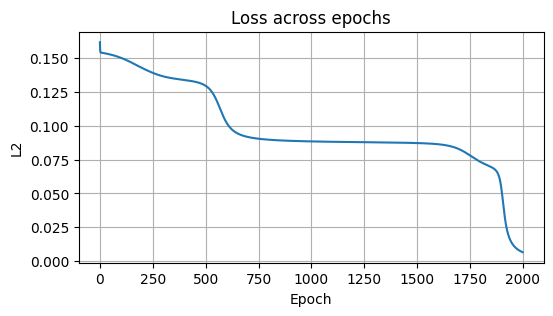

In [124]:
# Plotting the loss
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(epoch_loss)
ax.set_title('Loss across epochs')
ax.set_ylabel('L2')
ax.set_xlabel('Epoch')
ax.grid()
plt.show()

As you can see, the model has successfully learned how to fit the XOR function!

In [137]:
x = np.array([1,1]).reshape(-1, 1)
network = feedforward(network, x)
prediction = int(network['output']['prediction'][0][0] > 0.7)

print(f'Input received: {x.flatten()}, Prediction: {prediction}')

Input received: [1 1], Prediction: 0


## Moons dataset
---

In [140]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler

# Generate moons dataset
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

# Normalize to [0, 1] for better sigmoid performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for our network: (features, samples)
inputs = X_scaled.T  # shape: (2, 500)
tgts = y.reshape(1, -1)  # shape: (1, 500)

In [141]:
# Network setup
N_in = 2
N_out = 1

network_config = {
    'layer_0': {'N_in': N_in, 'N_out': 8, 'activation': 'sigmoid'},
    'layer_1': {'N_in': 8, 'N_out': 8, 'activation': 'sigmoid'},
    'layer_2': {'N_in': 8, 'N_out': N_out, 'activation': 'sigmoid'},
}

network = init_network(network_config)
loss = 'L2'
learning_rate = 0.5
epochs = 300

epoch_loss = []

for epoch in range(epochs):
    running_loss = 0.0

    for i in range(inputs.shape[1]):
        x = inputs[:, i].reshape(-1, 1)
        y_true = tgts[:, i].reshape(-1, 1)
        network = feedforward(network, x)
        running_loss += LOSSES[loss]['function'](network['output']['prediction'], y_true)[0][0]
        network = backprop(network, loss, y_true)
        network = gradient_descent(network, learning_rate)

    epoch_loss.append(running_loss / inputs.shape[1])


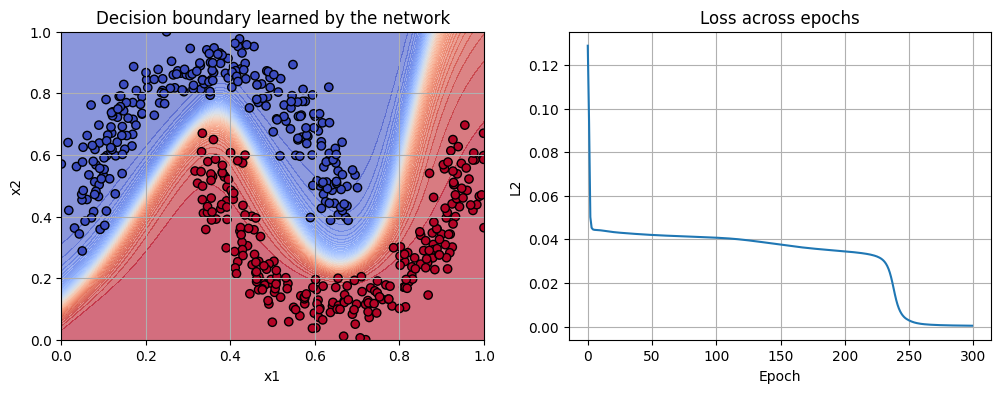

In [144]:
# Visualize decision boundary
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
grid = np.c_[xx.ravel(), yy.ravel()].T  # shape: (2, 10000)

Z = []
for i in range(grid.shape[1]):
    x = grid[:, i].reshape(-1, 1)
    network = feedforward(network, x)
    Z.append(network['output']['prediction'][0][0])

Z = np.array(Z).reshape(xx.shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolors='k')
axs[0].set_title('Decision boundary learned by the network')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].grid()

axs[1].plot(epoch_loss)
axs[1].set_title('Loss across epochs')
axs[1].set_ylabel('L2')
axs[1].set_xlabel('Epoch')
axs[1].grid()

plt.show()